In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from ultralytics import YOLO
import os

In [2]:
data = pd.read_csv('../data/interim/annots_imgs_merged.csv')
scatter = data[data['chart-type'] == 'scatter']
scatter = scatter[['data-series','visual-elements.scatter points','file_name','image_path']]
scatter.columns = ['data_series','data_coords','name','path']
scatter.reset_index(drop=True, inplace=True)
scatter.head()

,data_series,data_coords,name,path
0,"[{'x': 1949.4200576738224, 'y': 66.68303958393...","[[{'x': 89.33333333333334, 'y': 75.59999999999...",e91e28111e86,../data/interim/Scatterplots/e91e28111e86.jpg
1,"[{'x': 0.9445463278316278, 'y': 52.13870797394...","[[{'x': 68.76190476190474, 'y': 188.2023809523...",66dd2a250237,../data/interim/Scatterplots/66dd2a250237.jpg
2,"[{'x': 0.8933632249058832, 'y': 5.440194292653...","[[{'x': 93.33333333333333, 'y': 210.9666666666...",497a547454d7,../data/interim/Scatterplots/497a547454d7.jpg
3,"[{'x': 0.9873584566532869, 'y': 30.64333251170...","[[{'x': 67.83333333333334, 'y': 167.15}, {'x':...",07fb50377c3c,../data/interim/Scatterplots/07fb50377c3c.jpg
4,"[{'x': 1989.854169237731, 'y': 31.103360811667...","[[{'x': 105.83333333333334, 'y': 212.799999999...",daa43320159b,../data/interim/Scatterplots/daa43320159b.jpg


In [3]:
model = YOLO('/Users/matt/Desktop/graphs-capstone/models/scatterplot_model.pt')

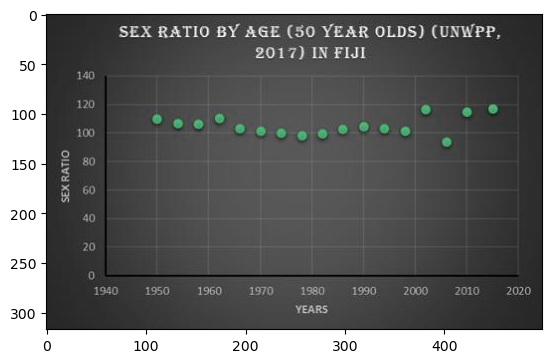

In [4]:
# Test image
path = scatter['path'].values[4004]
img = cv2.imread(path)
plt.imshow(img)
plt.show()

In [5]:
# Predict on the image
results = model(path)


image 1/1 /Users/matt/Desktop/graphs-capstone/notebooks/../data/interim/Scatterplots/3357aa5409e5.jpg: 416x640 17 ps, 367.6ms
Speed: 28.9ms preprocess, 367.6ms inference, 40.1ms postprocess per image at shape (1, 3, 416, 640)


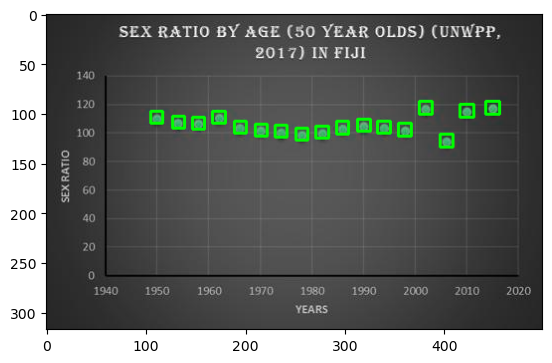

In [6]:
# Extract bboxes from model prediction
bbox_pred = []
res = results[0].boxes.data
for bbox in res:
    x1, y1, x2, y2, probs, pred = bbox
    bbox_pred.append((int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())))


copy = img.copy()
for bbox in bbox_pred:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(copy)
plt.show()

# Testing on the Rest of the scatterplots:

In [8]:
test_df = scatter[4001:].reset_index(drop=True)

In [10]:
test_df.head()

,data_series,data_coords,name,path
0,"[{'x': 1989.913726916394, 'y': 74844.885658571...","[[{'x': 130.66666666666666, 'y': 113.300000000...",10cb41f2d2b1,../data/interim/Scatterplots/10cb41f2d2b1.jpg
1,"[{'x': 2023.8645418326694, 'y': 1473937449.879...","[[{'x': 136.8, 'y': 137.14999999999998}, {'x':...",2e6f479f40e4,../data/interim/Scatterplots/2e6f479f40e4.jpg
2,"[{'x': 0.9901858284712146, 'y': 657296.9043436...","[[{'x': 99.57142857142857, 'y': 271.7333333333...",d38029494ecd,../data/interim/Scatterplots/d38029494ecd.jpg
3,"[{'x': 1949.989194381078, 'y': 110.07183552142...","[[{'x': 111.5, 'y': 105.14999999999998}, {'x':...",3357aa5409e5,../data/interim/Scatterplots/3357aa5409e5.jpg
4,"[{'x': 1990.0, 'y': 6.992269068303181}, {'x': ...","[[{'x': 54.66666666666667, 'y': 159.8833333333...",01850b694f00,../data/interim/Scatterplots/01850b694f00.jpg


In [12]:
dataframes = []
for i in range(len(test_df)):
    # extract xy coordinates from data_coords column
    coords = test_df['data_coords'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = test_df['path'][i]
    name = test_df['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    xy_coords = []
    for data_point in coords_list[0]:
        xy_coords.append((data_point['x'],data_point['y']))

    # Transform the xy coords into YOLO bboxes 
    bboxes = []
    for xy in xy_coords:
        x, y = xy
        bbox = (int(x)/width, int(y)/height, 12/width, 12/height)
        bboxes.append(bbox)

    # Save into list of dataframe
    yolo = pd.DataFrame(bboxes, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)
yolo_df['path'].nunique()

7242

In [13]:
yolo_df

,path,name,class,x,y,w,h
0,../data/interim/Scatterplots/10cb41f2d2b1.jpg,10cb41f2d2b1,0,0.255906,0.368078,0.023622,0.039088
1,../data/interim/Scatterplots/10cb41f2d2b1.jpg,10cb41f2d2b1,0,0.279528,0.361564,0.023622,0.039088
2,../data/interim/Scatterplots/10cb41f2d2b1.jpg,10cb41f2d2b1,0,0.295276,0.348534,0.023622,0.039088
3,../data/interim/Scatterplots/10cb41f2d2b1.jpg,10cb41f2d2b1,0,0.316929,0.348534,0.023622,0.039088
4,../data/interim/Scatterplots/10cb41f2d2b1.jpg,10cb41f2d2b1,0,0.338583,0.342020,0.023622,0.039088
...,...,...,...,...,...,...,...
20,../data/interim/Scatterplots/65e531ac0031.jpg,65e531ac0031,0,0.575697,0.731343,0.023904,0.035821
21,../data/interim/Scatterplots/65e531ac0031.jpg,65e531ac0031,0,0.533865,0.767164,0.023904,0.035821
22,../data/interim/Scatterplots/65e531ac0031.jpg,65e531ac0031,0,0.619522,0.752239,0.023904,0.035821
23,../data/interim/Scatterplots/65e531ac0031.jpg,65e531ac0031,0,0.752988,0.722388,0.023904,0.035821


In [14]:
folder_path = '/Users/matt/Desktop/graphs-capstone/data/interim/Scatterplots'

In [15]:
cols = ['name','class','x','y','w','h']
groupby_obj_df = yolo_df[cols].groupby('name')

In [16]:
def save_data(filename, folder_path, group_obj):
    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [19]:
filename_series = pd.Series(groupby_obj_df.groups.keys())
filename_series.apply(save_data,args=(folder_path, groupby_obj_df))

0       None
1       None
2       None
3       None
4       None
        ... 
7237    None
7238    None
7239    None
7240    None
7241    None
Length: 7242, dtype: object

In [20]:
metrics = model.val(data='/Users/matt/Desktop/graphs-capstone/data/YOLO/Scatterplots/data.yaml')

Ultralytics YOLOv8.0.136 🚀 Python-3.11.3 torch-2.0.1 CPU (Intel Core(TM) i5-8210Y 1.60GHz)
val: Scanning /Users/matt/Desktop/graphs-capstone/data/interim/Scatterplots... 7242 images, 4001 backgrounds, 1 corrupt: 100%|██████████| 11243/11243 [00:13<00:00, 861.83it/s]
val: WARNING ⚠️ /Users/matt/Desktop/graphs-capstone/data/interim/Scatterplots/3ef41bbc82c3.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.5469      2.2656      1.6523      1.3047        1.06      1.1875      2.4844      1.2227      2.6523      1.4668      1.7266      1.4839      2.1884      2.0857      1.6852      1.6328      1.6895      1.7422      1.7409      1.6797      2.2827      1.3867      3.3683      1.8047      3.4925      2.0938
      4.0278      1.8398]
val: New cache created: /Users/matt/Desktop/graphs-capstone/data/interim/Scatterplots.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 703/703 [59:37<00:00,  5.

In [21]:
# Extract actual bboxes from data
data = scatter['data_coords'].values[4001]
data = data.replace("'","\"")
data_list = json.loads(data)
bbox_actual = []
for row in data_list[0]:
    x1 = row['x'] - 6
    y1 = row['y'] - 6
    x2 = row['x'] + 6
    y2 = row['y'] + 6
    bbox_actual.append((x1,y1,x2,y2))

bbox_pred = sorted(bbox_pred)
bbox_actual = sorted(bbox_actual)

actual_df = pd.DataFrame(bbox_actual, columns=['x1','y1','x2','y2'])
pred_df = pd.DataFrame(bbox_pred, columns=['x1_pred','y1_pred','x2_pred','y2_pred'])

mean_diff_x1 = abs(pred_df['x1_pred']-actual_df['x1']).mean()
mean_diff_y1 = abs(pred_df['y1_pred']-actual_df['y1']).mean()
mean_diff_x2 = abs(pred_df['x2_pred']-actual_df['x2']).mean()
mean_diff_y2 = abs(pred_df['y2_pred']-actual_df['y2']).mean()